In [2]:
import numpy as np
import pandas as pd
from scipy.stats import laplace
import scipy.stats
import psycopg2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta  
import threading

In [3]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

def execRangeQuery(params_dic,dates):
    query = """
    SELECT
    sum(count_)
    FROM _775147
    WHERE
    time_ >= '{date0}'
    AND time_ <=  '{date1}'
    ;
    """.format(date0 = dates[0], date1 = dates[1])
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")

def execQuery(params_dic,query):
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")
#"""select count(*) as number_of_dates, count(DISTINCT  count_) as distinct_count from _775147;"""
query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

query = """select count_ from _775147;"""
result = execQuery(param_dic, query)
"""
print(result)
print(type(result))
print(type(result[0]))
print((str(result[0][0])))
"""
counts = [(count[0]) for count in result]

Executed query and closed connection.
Executed query and closed connection.


In [4]:
def add_missing_dates(old_dates):
    start_date = dates[0]
    end_date = dates[-1]
    all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
    return [(date.date()) for date in all_dates]
    
def add_missing_counts(old_counts, old_dates, new_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(new_dates))
        for i, date in enumerate(new_dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts

In [5]:
all_dates = add_missing_dates(dates)
all_counts =  add_missing_counts(counts, dates, all_dates)

In [6]:
np.random.uniform(-1,0,1000)
def randomized_response(x, p=0.1):
    if np.random.uniform(0,1) < p:
        return x
    else:
        return np.random.randint(2)

In [7]:
randomized_response(1)

1

In [16]:
def get_index(date_idx, n_layers):
    """Calculates the path of index in full binary string

    Parameters:
    date_idx (int): The node in the bouttom layer we want to calculate a path to. 
    The bottom layer has index from 0 to 2**h-1
    n_layers (int): The height of the full binary tree. starts from 0 

    Returns:
    list: of index in the path from the starting from the bottom and going up

    """
    idx = []
    for i in np.arange(0,n_layers):
        if i == 0:
            idx.append(int(date_idx))
        else:
            idx.append(int(idx[i-1]//2))
    idx.append(0)
    return idx

def left_or_right(current, nxt):
    #0 is left 1 is right
    #print(f'current = {current}, nxt = {nxt}')
    if nxt == 0:
        #print('nxt == 0')
        return 0
    if current == 0 and current < nxt:
        #print('current == 0 and current < nxt')
        return 1
    elif 2* current < nxt:
        #print('2* current < nxt')
        return 1
    else:
        #print('else')
        return 0
    
def left_or_right_list(path):
    #print(path)
    #0 is left 1 is right
    direction_lst = []
    for i in range(len(path)-1):
        #print(f'i = {i}')
        current = path[i]
        nxt = path[i+1]
        #print(f'current = {current}, nxt = {nxt}')
        if nxt == 0:
            #print('nxt == 0')
            direction_lst.append(0)
        elif current == 0 and current < nxt:
            #print('current == 0 and current < nxt')
            direction_lst.append(1)
        elif 2* current < nxt:
            #print('2* current < nxt')
            direction_lst.append(1)
        else:
            #print('else')            
            direction_lst.append(0)
            
    return direction_lst

In [17]:
def HH_OUE(dates, counts, OUE, epsilon):
    h = int(np.ceil(np.log2(len(dates))))
    prob = np.full(h+1,1/(h+1))
    print(f'h = {h}')
    
    tree_levels = []
    for i in np.arange(0,h+1):
        level = np.zeros(int(2**np.ceil(i)))
        tree_levels.append(level) 
    
    #OUE response
    vfunc = np.vectorize(OUE, otypes = [int])
    
    
    for index, (date, day_count) in enumerate(zip(dates, counts)):
        #print(f'index = {index}, date = {date}, count = {day_count}')
        idxs = get_index(index,h)
        idxs.reverse()
        
        for person in range(int(day_count)):
            #print(person)
            level = np.random.choice(np.arange(0, h+1), p = prob ) 
            #print(f'we got level = {level}')
            tree_level = np.zeros(2**level,dtype=int)
            #print(idxs[level])
            #tree_level[index] = 1
            #get_index
            tree_level[idxs[level]] = 1
            perb_tree_level = vfunc(tree_level,epsilon)
            tree_levels[level] = tree_levels[level] + perb_tree_level
        #print(f'index = {index}, date = {type(date)}, count = {count}')
        #print(index, value1 + value2)  # for Python 2 use: `print index, value1 + value2` (no braces)
    return tree_levels

In [172]:
class HH_OLH_cc:
    def __init__(self, epsilon, dates, counts):
        """Setup of the datastructere
        Parameters:
        T (int): The lenght of the stream
        epsilon (float): The height of the full binary tree. 
        dates (Array): The dates of the stream
        counts (Array): The count for each of the dates
        Returns:
        A epsilon differintial datastructe
        """
        self.epsilon = epsilon
        self.all_dates = dates
        self.all_counts = counts
        if len(dates) < (dates[-1]-dates[0]).days:
            print('here')
            self.all_dates = self.__add_missing_dates(dates)
            self.all_counts = self.__add_missing_counts(counts,dates)
            
        #Make dict for date indexing
        values = np.arange(0,len(self.all_dates))
        zip_iterator = zip(self.all_dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        self.h = int(np.ceil(np.log2(len(self.all_dates))))
        self.level_prob = np.full(self.h+1,1/(self.h+1))
    
        self.tree_levels = self.__process(self.all_dates, self.all_counts)
        #Check if we are we have missing dates.
        
    def __add_missing_dates(self, old_dates):
        """Add missing dates in a list
        Parameters:
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        start_date = dates[0]
        end_date = dates[-1]
        all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
        return [(date.date()) for date in all_dates]
    
    def __add_missing_counts(self, old_counts, old_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(self.dates))
        for i, date in enumerate(self.dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts
    
    def __process(self, dates, counts):
        tree_levels = []
        for i in np.arange(0,self.h+1):
            level = np.zeros(int(2**np.ceil(i)))
            tree_levels.append(level)
        
        for index, (date, day_count) in enumerate(zip(dates, counts)):
            #print(f'index = {index}, date = {date}, count = {count}')
            idxs = self.get_index(index,self.h)
            idxs.reverse()

            for person in range(int(day_count)):
                level = np.random.choice(np.arange(0, self.h+1), p = self.level_prob ) 
                tree_level = np.zeros(2**level,dtype=int)
                
                if level != 0:
                    response = self.OLH_func(idxs[level], (2**level))
                else:
                    response = 0
                tree_levels[level][response] = tree_levels[level][response] + 1

        return tree_levels

    def get_index(self, date_idx, n_layers):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 

        Returns:
        list: of index in the path from the starting from the bottom and going up
        """
        idx = []
        for i in np.arange(0,n_layers):
            if i == 0:
                idx.append(int(date_idx))
            else:
                idx.append(int(idx[i-1]//2))
        idx.append(0)
        return idx
    
    def OLH_func(self, correct_answear, g):
        if np.random.uniform(0,1) < np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1):
            #print('if')
            return correct_answear
        else:
            return np.random.randint(low = 0, high = g)
    
    def OLH_aggre(self, count, N, g):
        p = np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1)
        #print(p - 1/g)
        #print(f'p = {p}')
        return (count- N/g) / (p)
    
    def answer(self, dates):
        """Calculates the path of index in full binary string

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The private range count
        """
            
        date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
        date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()


        idx_0 = self.idx_dict[date_obj_0]
        idx_1 = self.idx_dict[date_obj_1]

        idx_left = idx_0-1
        idx_right = idx_1+1

        path_to_left = np.flip(np.array(get_index(idx_left,self.h)))
        path_to_right = np.flip(np.array(get_index(idx_right,self.h)))

        if idx_0 == 0:
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])
            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            sum_level = 0.0
            sum_all = 0.0
            
            for i in range(len(left_or_right_list_rightside)):
                if left_or_right_list_rightside[i] == 1:
                    node = self.tree_levels[i+level_offset][path_to_right[i+level_offset]-1]
                    #print('Node')
                    #print(node)
                    #print('With all')
                    #contribution_all = self.OLH_aggre(node, np.sum(self.all_counts), len(self.all_dates))
                    #sum_all = sum_all + self.OLH_aggre(node, np.sum(self.all_counts), len(self.all_dates))
                    #print(contribution_all)
                    #print('with level')
                    contribution_level = self.OLH_aggre(node* self.h, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
                    sum_level = sum_level + contribution_level
                    #print(self.tree_levels[i+level_offset])
                    #print(contribution_level)
                    #print(np.sum(self.tree_levels[i+level_offset]))
                    #print(len(self.tree_levels[i+level_offset]))
                    
            print('____________________________')
            print(sum_level)
            #print(sum_all)
            return sum_level 
            
        elif idx_1 == np.max(self.idx_dict.values):
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])
            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            for i in range(len(left_or_right_list_leftside)):
                if left_or_right_list_leftside[i] == 0:
                    node = self.tree_levels[i+level_offset][path_to_left[i+level_offset]+1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    
        else:
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])

            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            for i in range(len(left_or_right_list_leftside)):
                if left_or_right_list_leftside[i] == 0:
                    node = self.tree_levels[i+level_offset][path_to_left[i+level_offset]+1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    
            
            for i in range(len(left_or_right_list_rightside)):
                if left_or_right_list_rightside[i] == 1:
                    node = self.tree_levels[i+level_offset][path_to_right[i+level_offset]-1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    

        print(all_counts[idx_0:idx_1])
        print(f'Real answer is {np.sum(all_counts[idx_0:idx_1+1])}')
        #print(OLH_answer(count, epsilon, np.sum(OLH_count), D))
        #D = len(all_dates) 

query_dates = ('2014-01-02','2014-01-9')
epsilon = 0.7
local_HH = HH_OLH_cc(epsilon, all_dates[:32], all_counts[:32])

print(local_HH.answer(query_dates))
print(np.sum(all_counts[:8]))

for level in local_HH.tree_levels:
    print(level)


____________________________
2502.8271299089433
2502.8271299089433
1681.0
[1030.]
[488. 510.]
[252. 255. 234. 278.]
[105. 153. 128. 141. 135. 111. 119. 146.]
[61. 57. 61. 75. 58. 53. 62. 56. 66. 66. 62. 61. 63. 76. 63. 58.]
[29. 37. 31. 29. 24. 31. 31. 37. 21. 36. 24. 32. 33. 37. 35. 35. 45. 20.
 37. 39. 30. 32. 23. 36. 22. 26. 37. 33. 27. 28. 37. 24.]


In [106]:
print(local_HH.h)

7


In [170]:
#Sanity check
print(np.sum(all_counts[:32]))
sum_levels = [np.sum(a) for a in local_HH.tree_levels]
sum_all_levels = np.sum(sum_levels)
print(f'Expected sum of levels = {sum_all_levels/len(local_HH.tree_levels)}')
print(sum_levels)
"""
for level in local_HH.tree_levels:
    print(level)
    level_sum = np.sum(level)
    print(f'Sum of level = {level_sum}')
"""

6081.0
Expected sum of levels = 1013.5
[1000.0, 1016.0, 1024.0, 1004.0, 1025.0, 1012.0]


"\nfor level in local_HH.tree_levels:\n    print(level)\n    level_sum = np.sum(level)\n    print(f'Sum of level = {level_sum}')\n"

In [111]:
epsilons = np.array([2,1.4,1.2,1,0.8,0.7,0.5,0.4,0.3])
error_dicts = {}
test_dates = all_dates[:128].copy()
test_counts = all_counts[:128].copy()
for e in epsilons:
    print(e)
    number_of_queries = 100
    range_dates = ('2014-01-02','2014-01-9')
    answears = np.zeros(number_of_queries)
    corret_answear = np.sum(all_counts[0:8])
    for i in range(0,number_of_queries):
        local = HH_OLH_cc(e, test_dates, test_counts)
        a = local.answer(range_dates)
        answears[i] = a
    error = np.abs(corret_answear-answears)
    max_error = np.amax(error)
    min_error = np.amin(error)
    true_values = np.full(number_of_queries, corret_answear)
    #vfunc = np.vectorize(relative_error)
    #rel_erorrs = vfunc(answears, corret_answear)
    mse = mean_squared_error(true_values, answears)
    error_dicts[e] = {'mse': mse, 'max': max_error, 'min': min_error, 'abs': np.mean(error)}



2.0
1.4
1.2
1.0
0.8
0.7
0.5
0.4
0.3


In [112]:
#Getting all error values from dict
n = len(error_dicts)
mse_errors = np.zeros(n)
min_errors = np.zeros(n)
max_errors = np.zeros(n)
abs_errors = np.zeros(n)

for num, item in enumerate(error_dicts.items()):
    mse_errors[num] = item[1]['mse']
    min_errors[num] = item[1]['min']
    max_errors[num] = item[1]['max']
    abs_errors[num] = item[1]['abs']

In [113]:
error_stack = np.vstack((min_errors,mse_errors,max_errors,abs_errors)).flatten()
min_labels = np.full(min_errors.size, 'min errors')
mse_labels = np.full(mse_errors.size, 'mse errors')
max_labels = np.full(max_errors.size, 'max errors')
abs_labels = np.full(abs_errors.size, 'abs errors')


labels_stack = np.vstack((min_labels,mse_labels,max_labels,abs_labels)).flatten()
epsilons_stack = np.vstack((epsilons,epsilons,epsilons,epsilons)).flatten()


In [114]:
seaborn_df = pd.DataFrame({'epsilons':epsilons_stack, 'errors':error_stack,'labels':labels_stack})
seaborn_df.to_csv('local_hh_seaborn_plotting_data.csv',index=False)

In [115]:
all_data = pd.DataFrame({'epsilons':epsilons, 'min_errors':min_errors,'max_errors':min_errors,'mse_errors':mse_errors,'abs_errors':abs_errors})
all_data.to_csv('local_hh_plotting_data.csv',index=False)

In [116]:
sns.set()

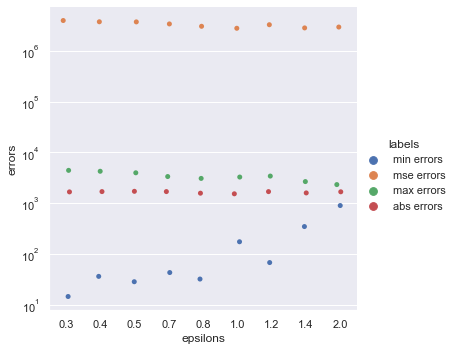

In [117]:
sns_plot = sns.catplot(x="epsilons", y="errors", hue="labels", data=seaborn_df)
sns_plot.set(yscale="log")
sns_plot.savefig("local_hh_AllErrors.png")


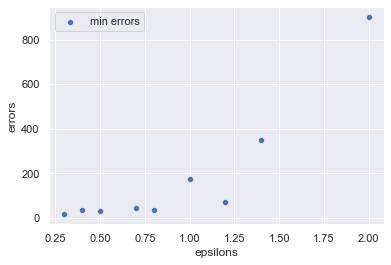

In [118]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'min errors'], x ='epsilons', y ='errors')
plt.legend(labels=['min errors'])
sns_plot.get_figure().savefig('con_min_error.png') 

In [119]:
epsilon = 1.
test_dates = all_dates[:128].copy()
test_counts = all_counts[:128].copy()
number_of_queries = 100
range_dates = ('2014-01-02','2014-01-9')
answears = np.zeros(number_of_queries)
corret_answear = np.sum(all_counts[0:8])
for i in range(0,number_of_queries):
    local = HH_OLH_cc(epsilon, test_dates, test_counts)
    a = local.answer(range_dates)
    answears[i] = a





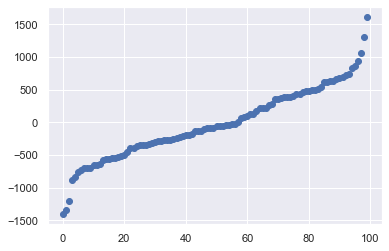

In [126]:
import matplotlib.pyplot as plt
x = np.arange(0,number_of_queries)
answears.sort()
plt.scatter(x,answears )
plt.show()

In [122]:
answears

array([  824.14385265, -1411.59587218,     8.5551265 ,  -707.22379051,
        -724.3340435 ,  -345.05676876,   -19.96196183,   285.17088327,
        -564.63834887,  -841.25410564,   268.06063027,   624.52423436,
         396.38752774,   225.28499778,  -296.5777186 ,  -205.32303595,
         459.12512206,  -573.19347537,  -390.68411008,   390.68411008,
         -39.92392366,  -268.06063027,   134.03031514,   541.82467821,
         861.21606747,   667.29986685,  -524.71442521,   353.61189525,
          65.58930315,  -265.20892144,  -761.40625833,    74.14442965,
         -99.80980914,   367.87043942,  -544.67638704,   633.07936086,
         -88.40297381,   -94.10639148,  -188.21278296,   516.15929872,
        1060.83568576,  -225.28499778,   499.04904572, -1346.00656903,
         -57.03417665, -1206.27283623,   -25.66537949,  -886.88144697,
         935.36049712,   125.47518864,  -134.03031514,  -692.96524634,
        -131.1786063 ,  -290.87430093,  -128.32689747,    94.10639148,
      

In [120]:
epsilon = 1.
test_dates = all_dates[:64].copy()
test_counts = all_counts[:64].copy()
number_of_queries = 100
range_dates = ('2014-01-02','2014-01-9')
answears_64 = np.zeros(number_of_queries)
corret_answear = np.sum(all_counts[0:8])
for i in range(0,number_of_queries):
    local = HH_OLH_cc(epsilon, test_dates, test_counts)
    a = local.answer(range_dates)
    answears_64[i] = a

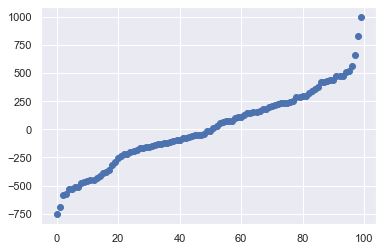

In [128]:
import matplotlib.pyplot as plt
x = np.arange(0,number_of_queries)
answears_64.sort()
plt.scatter(x,answears_64 )
plt.show()

In [121]:
epsilon = 1.
test_dates = all_dates[:32].copy()
test_counts = all_counts[:32].copy()
number_of_queries = 100
range_dates = ('2014-01-02','2014-01-9')
answears_32 = np.zeros(number_of_queries)
corret_answear = np.sum(all_counts[0:8])
for i in range(0,number_of_queries):
    local = HH_OLH_cc(epsilon, test_dates, test_counts)
    a = local.answer(range_dates)
    answears_32[i] = a

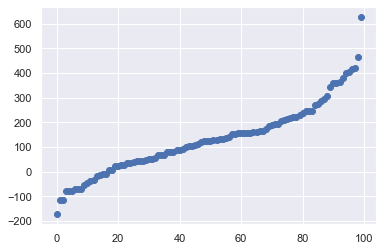

In [127]:
import matplotlib.pyplot as plt
x = np.arange(0,number_of_queries)
answears_32.sort()
plt.scatter(x,answears_32 )
plt.show()

In [ ]:
print(np.argmax(all_counts))

In [96]:
class HH_OLH_degree:
    def __init__(self, epsilon, degree, dates, counts):
        """Setup of the datastructere
        Parameters:
        T (int): The lenght of the stream
        epsilon (float): The height of the full binary tree. 
        dates (Array): The dates of the stream
        counts (Array): The count for each of the dates
        Returns:
        A epsilon differintial datastructe
        """
        self.epsilon = epsilon
        self.all_dates = dates
        self.all_counts = counts
        #Check if we are we have missing dates.
        if len(dates) < (dates[-1]-dates[0]).days:
            #print('here')
            self.all_dates = self.__add_missing_dates(dates)
            self.all_counts = self.__add_missing_counts(counts,dates)
            
        #Make dict for date indexing
        values = np.arange(0,len(self.all_dates))
        zip_iterator = zip(self.all_dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        self.degree = degree
        self.h = int(np.ceil(np.log(len(self.all_dates)) / np.log(degree)))
        self.level_prob = np.full(self.h+1,1/(self.h+1))
    
        self.tree_levels = self.__process(self.all_dates, self.all_counts)
        
    def __add_missing_dates(self, old_dates):
        """Add missing dates in a list
        Parameters:
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        start_date = dates[0]
        end_date = dates[-1]
        all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
        return [(date.date()) for date in all_dates]
    
    def __add_missing_counts(self, old_counts, old_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(self.dates))
        for i, date in enumerate(self.dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts
    
    def __process(self, dates, counts):
        tree_levels = []
        for i in np.arange(0,self.h+1):
            level = np.zeros(int(self.degree**np.ceil(i)))
            tree_levels.append(level)
        
        for index, (date, day_count) in enumerate(zip(dates, counts)):
            #print(f'index = {index}, date = {date}, count = {day_count}')
            idxs = self.get_index(index,self.h)
            idxs.reverse()
            for person in range(int(day_count)):
                level = np.random.choice(np.arange(0, self.h+1), p = self.level_prob ) 
                tree_level = np.zeros(self.degree**level,dtype=int)
                
                if level != 0:
                    response = self.OLH_func(idxs[level], (self.degree**level))
                else:
                    response = 0
                tree_levels[level][response] = tree_levels[level][response] + 1

        return tree_levels

    def get_index(self, date_idx, n_layers):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 

        Returns:
        list: of index in the path from the starting from the bottom and going up

        """
        idx = []
        for i in np.arange(0,n_layers):
            if i == 0:
                idx.append(int(date_idx))
            else:
                idx.append(int(idx[i-1]//self.degree))
        idx.append(0)
        return idx
    
    def get_group(self, idx, n_layers, level):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 0 index

        Returns:
        list: of index in the path from the starting from the bottom and going up

        """
        if level == 0:
            return id
        elif idx == 0:
            return np.arange(0,self.degree)
        else:
            group_index = idx //self.degree
            level_indicis = np.arange(0,self.degree**level)

            split_ratio = (len(level_indicis) // self.degree)
            level_indicis_split = np.array_split(level_indicis, split_ratio)

            return level_indicis_split[group_index]
    
    def OLH_func(self, x, g):
        if np.random.uniform(0,1) < np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1):
            #print('if')
            return x
        else:
            #print('Uniform')
            return np.random.randint(low = 0, high = g)
    
    def OLH_aggre(self, count, N, g):
        p = np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1)
        #print(p - 1/g)
        #print(f'p = {p}')
        return (count- N/g) / (p)
    
    def turns_right(self, path):
        #0 is left 1 is right
        direction_lst = []
        for i in range(len(path)-1):
            #print(f'i = {i}')
            current = path[i]
            nxt = path[i+1]
            #print(f'current = {current}, nxt = {nxt}')
            if nxt == 0:
                #We went left
                #print('nxt == 0')
                direction_lst.append(0)
            elif current == 0 and current < nxt:
                #We went right
                #print('current == 0 and current < nxt')
                direction_lst.append(1)
            elif degree * current < nxt:
                #We went right
                #print('2* current < nxt')
                direction_lst.append(1)
            else:
                #print('else')            
                direction_lst.append(0)

        return direction_lst

    def turns_left(self, path):
        #print(path)
        #0 is left 1 is right
        direction_lst = []
        for i in range(len(path)-1):
            #print(f'i = {i}')
            current = path[i]
            nxt = path[i+1]
            #print(f'current = {current}, nxt = {nxt}')
            #Checks
            if nxt == 0:
                #We went left
                #print('nxt == 0')
                direction_lst.append(0)
            #Checks
            elif nxt == current*degree + degree - 1:
                #We went right
                #print(current * degree)
                #print(current * degree + degree)
                #print('current * degree != nxt')
                direction_lst.append(1)
            elif current == 0 and current < nxt:
                #We went left
                #print('current == 0 and current < nxt')
                direction_lst.append(0)
            else:
                #print('else')            
                direction_lst.append(0)

        return direction_lst
    
    def answer(self, dates):
        """Calculates the path of index in full binary string

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The private range count
        """
            
        date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
        date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()


        idx_0 = self.idx_dict[date_obj_0]
        idx_1 = self.idx_dict[date_obj_1]

        idx_left = idx_0-1
        idx_right = idx_1+1

        path_to_left = np.flip(np.array(self.get_index(idx_left,self.h)))
        path_to_right = np.flip(np.array(self.get_index(idx_right,self.h)))
        #Starting in 0
        if idx_0 == 0:

            left_or_right_list_rightside = self.turns_right(path_to_right)

            #level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            level_offset = 1
            sum_level = 0.0
            
            for i in range(len(left_or_right_list_rightside)):
                #print(f'i = {i}')
                #print(left_or_right)
                #print(f'We are looking at {left_or_right_list_rightside[i]}')
                if left_or_right_list_rightside[i] == 1:
                    #print(f'We are at level {i+level_offset}')
                    #print(f'We are at node {path_to_right[i+level_offset]} in the path')
                    #print('We went right')        
                    #print('We need to count the left one')
                    group = self.get_group(path_to_right[i+level_offset],0 , i+level_offset)
                    print(group)
                    idx_sss = np.where(group == path_to_right[i+level_offset])[0][0]
                    #print(idx_sss)
                    #print(group[:idx_sss])
                    #print(hhs[i+level_offset][group[:idx_sss]])
                    #print(hhs[i+level_offset][path_to_right[i+level_offset]-1])
                    count_nodes = self.tree_levels[i+level_offset][group[:idx_sss]]
                    print(count_nodes)
                    for node in count_nodes:
                        print(node)
                        contribution_level = self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
                        print(contribution_level)
    
        elif idx_1 == np.max(self.idx_dict.values):
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])
            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            for i in range(len(left_or_right_list_leftside)):
                if left_or_right_list_leftside[i] == 0:
                    node = self.tree_levels[i+level_offset][path_to_left[i+level_offset]+1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    
        else:
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])

            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            for i in range(len(left_or_right_list_leftside)):
                if left_or_right_list_leftside[i] == 0:
                    node = self.tree_levels[i+level_offset][path_to_left[i+level_offset]+1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    
            
            for i in range(len(left_or_right_list_rightside)):
                if left_or_right_list_rightside[i] == 1:
                    node = self.tree_levels[i+level_offset][path_to_right[i+level_offset]-1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    

        print(all_counts[idx_0:idx_1])
        print(f'Real answer is {np.sum(all_counts[idx_0:idx_1+1])}')
        #print(OLH_answer(count, epsilon, np.sum(OLH_count), D))
        #D = len(all_dates) 

query_dates = ('2014-01-02','2014-01-13')
epsilon = 0.7
degree = 4
local_HH = HH_OLH_degree(epsilon, degree, all_dates[:63], all_counts[:63])
local_HH.answer(query_dates)

for level in local_HH.tree_levels:
    print(level)


Paths
[ 0 -1 -1 -1]
[ 0  0  3 12]
[0 1 2 3]
[205. 223. 218.]
205.0
25.346338670613427
223.0
177.424370694294
218.0
135.1804729099383
[239. 118. 129.   2. 293. 362. 288. 250.  76.  89.   1.]
Real answer is 2100.0
[3180.]
[838. 753. 837. 891.]
[205. 223. 218. 207. 183. 186. 208. 221. 201. 179. 197. 214. 185. 201.
 193. 211.]
[59. 56. 50. 47. 62. 53. 55. 36. 42. 50. 54. 61. 45. 57. 43. 33. 44. 47.
 67. 54. 50. 54. 55. 42. 48. 48. 52. 58. 49. 43. 61. 38. 35. 61. 58. 55.
 59. 38. 54. 61. 62. 38. 44. 47. 44. 55. 48. 64. 52. 53. 51. 44. 47. 68.
 53. 58. 49. 48. 56. 47. 50. 59. 51. 65.]


7
7


In [ ]:
def max_disjoint_B_adic_ranges(r, B):
    # r = length, B = log base
    #Fact 3
    #Any sub-range of length[a,b]of length r from [D] can be decomposed into ≤ (B−1)(2 logBr+1)disjoint B-adic ranges.
    #(B−1)(2 logBr+1)
    return (B-1)*(2* np.log(r+1) / np.log(B))

In [ ]:
B = 2
r = 20
print(max_disjoint_B_adic_ranges(r,B))
n = 74088
exp = 42
np.log(n) / np.log(exp)